# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import tensorflow as tf
import plot
import GPy
import gp_gpy as gp
import synch

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

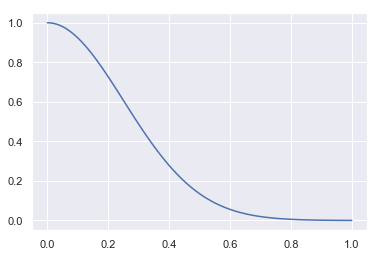

In [9]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

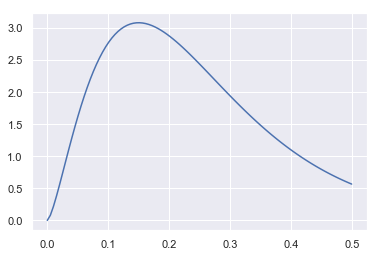

In [10]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

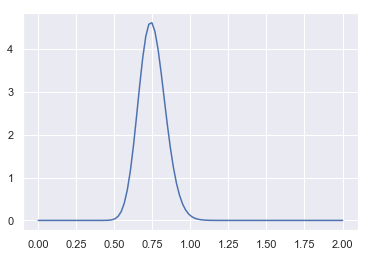

In [11]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

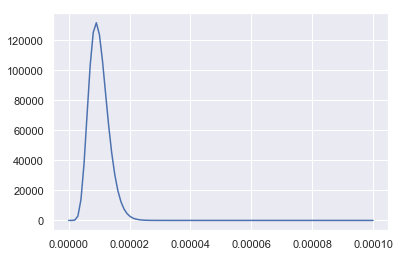

In [12]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [13]:
d_lat = train.lat.max() - train.lat.min()
d_lon = train.lon.max() - train.lon.min()
print(d_lat, d_lon)

0.0475797653198029 0.009510040283302601


# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

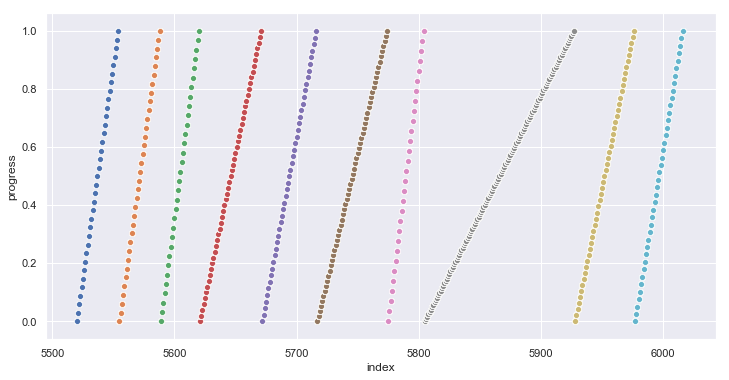

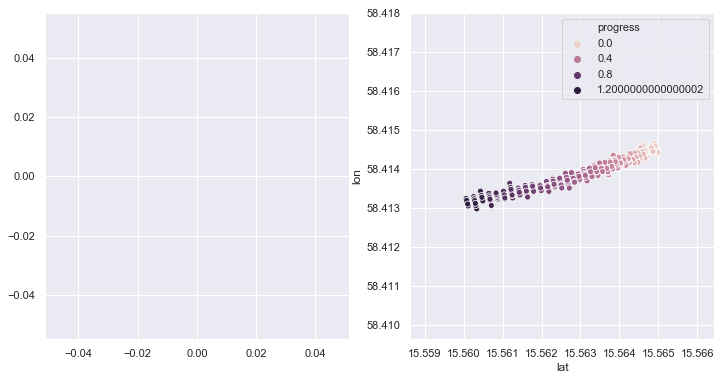

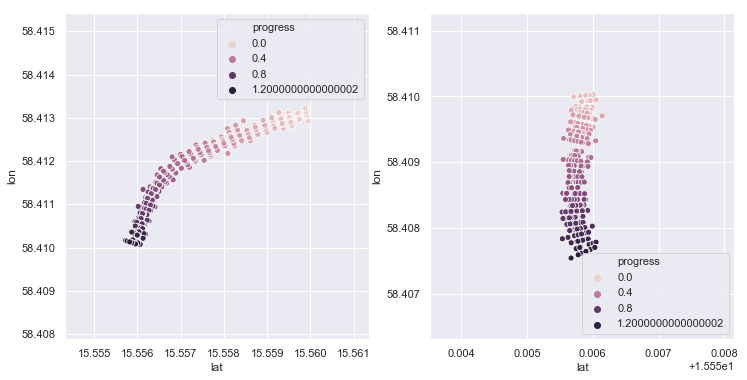

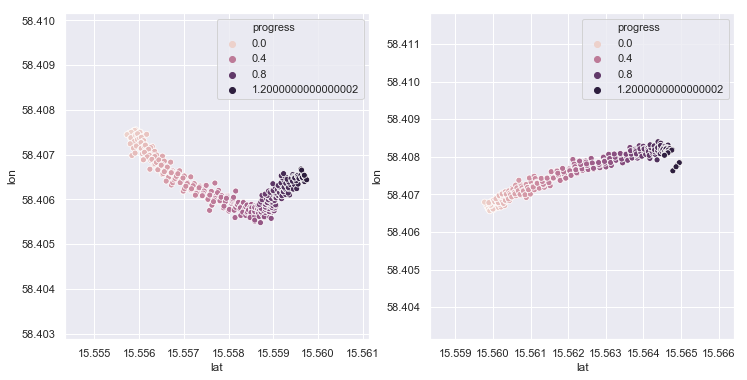

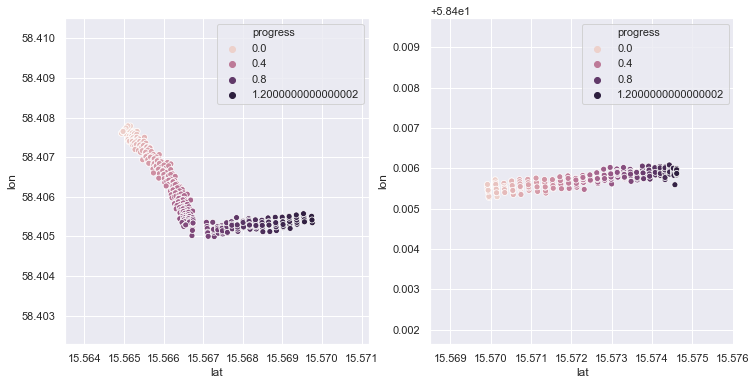

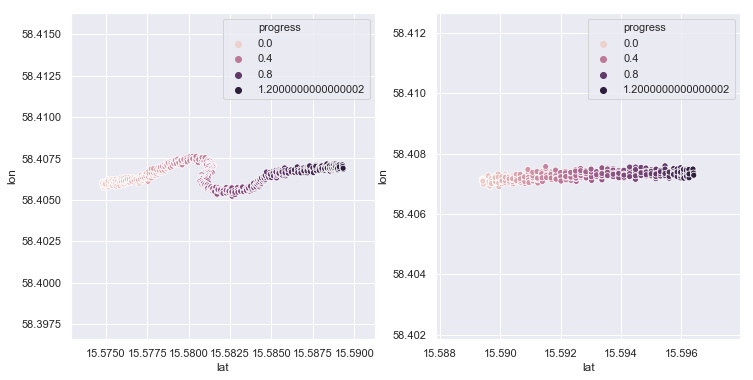

In [14]:
n_trajs = train.traj.unique()
traj_n = n_trajs[8]
traj = train[train.traj == traj_n]
traj_support = support[support.traj == traj_n]
train_traj = traj.append(traj_support)
plot.traj_progress(train_traj)
plot.traj_segment_grid(train_traj, 'lat', 'lon', hue='progress')

Having found a seg_n that seems typical we can now fit GPs for each of its segments.

In [27]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    d_lat = train.lat.max() - train.lat.min()
    d_lon = train.lon.max() - train.lon.min()
    X = seg[['lat', 'lon']].values
    Y = seg[['progress']]
    model = gp.build_synch(X, Y, route_n, seg_n)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.001))
    model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.2))
    model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.005, 0.00001))
    gp.train(model, n_restarts=5)
    print(model.model)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = {seg_n: train_gp(train_traj, route_n, traj_n, seg_n) for seg_n in n_segs}

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -657.5358236782645
Optimization restart 2/5, f = -657.5358237819162
Optimization restart 3/5, f = -657.5358237820265
Optimization restart 4/5, f = -657.5358237820108


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -657.5358237820483

Name : GP regression
Objective : -657.5358237820483
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |        priors      
  rbf.variance             |     0.4943868393432012  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |     0.8484903961085758  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.0013706736215316495  |      +ve      |    Ga(2.5, 5e+02)  
Optimization restart 1/5, f = -1221.5607267628232
Optimization restart 2/5, f = -1208.093933331253
Optimization restart 3/5, f = -1208.093933304602
Optimization restart 4/5, f = -1208.09393333203


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -1208.0939333309825

Name : GP regression
Objective : -1221.5607267628232
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |        priors      
  rbf.variance             |       5.83615208364204  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |    0.41437826052391075  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  4.590141815417705e-06  |      +ve      |    Ga(2.5, 5e+02)  
Optimization restart 1/5, f = -346.5437366454016
Optimization restart 2/5, f = -346.5437366452773
Optimization restart 3/5, f = -346.54373664542754
Optimization restart 4/5, f = -346.54373664227654


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -346.5437366454365

Name : GP regression
Objective : -346.5437366454365
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |        priors      
  rbf.variance             |   0.46689720476849195  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |    0.8836247822814488  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.004873099818394689  |      +ve      |    Ga(2.5, 5e+02)  


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1157.552526577043
Optimization restart 2/5, f = -1157.5525265626416
Optimization restart 3/5, f = -1157.552526565872
Optimization restart 4/5, f = -1157.5525265746746


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1157.5525265766769

Name : GP regression
Objective : -1157.552526577043
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |        priors      
  rbf.variance             |     1.3057005437185552  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |     0.6338800643023774  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.0005188167425836996  |      +ve      |    Ga(2.5, 5e+02)  


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1093.7812728827878
Optimization restart 2/5, f = -1093.7812728943443
Optimization restart 3/5, f = -1093.7812728947163
Optimization restart 4/5, f = -1093.781272838121


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1093.7812728731035

Name : GP regression
Objective : -1093.7812728947163
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |        priors      
  rbf.variance             |     1.3034193391591034  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |     0.7127938312754969  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.0004359131215318062  |      +ve      |    Ga(2.5, 5e+02)  


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -2054.2432373293323
Optimization restart 2/5, f = -2054.243237344996
Optimization restart 3/5, f = -2054.243237318795
Optimization restart 4/5, f = -2054.2432373822508


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -2054.2432373483603

Name : GP regression
Objective : -2054.2432373822508
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |        priors      
  rbf.variance             |       2.771062317998474  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |      0.4340185219939377  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  2.2251292155597235e-05  |      +ve      |    Ga(2.5, 5e+02)  
Optimization restart 1/5, f = -541.20352301514
Optimization restart 2/5, f = -541.2035230151218
Optimization restart 3/5, f = -541.2035230151025
Optimization restart 4/5, f = -541.2035230150578
Optimization restart 5/5, f = -541.2035230150709

Name : GP regression
Objective : -541.20352301514
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -4885.126836440736
Optimization restart 2/5, f = -4885.126836286469
Optimization restart 3/5, f = -4885.126836069316
Optimization restart 4/5, f = -4885.126836441683
Optimization restart 5/5, f = -4885.1268364383395


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance



Name : GP regression
Objective : -4885.126836441683
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |        priors      
  rbf.variance             |      0.8280758012728222  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |      0.4929708767001755  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  2.0474904342179498e-05  |      +ve      |    Ga(2.5, 5e+02)  


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1155.152983796394
Optimization restart 2/5, f = -1155.152983796293
Optimization restart 3/5, f = -1155.1529837964385
Optimization restart 4/5, f = -1155.1529837964472


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -1155.1529837848668

Name : GP regression
Objective : -1155.1529837964472
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |        priors      
  rbf.variance             |      0.6519817796668902  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |      0.9113417569875686  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.00046540929948706103  |      +ve      |    Ga(2.5, 5e+02)  


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -924.0038369989279
Optimization restart 2/5, f = -924.0038370022028
Optimization restart 3/5, f = -924.0038370036443
Optimization restart 4/5, f = -924.0038370040588
Optimization restart 5/5, f = -924.0038370037337

Name : GP regression
Objective : -924.0038370040588
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |        priors      
  rbf.variance             |     1.2416433912936669  |      +ve      |     Ga(1.2, 2.5)   
  rbf.lengthscale          |     0.7902836625066275  |      +ve      |  Ga(6.4e+02, 8e+02)
  Gaussian_noise.variance  |  0.0004534331340046525  |      +ve      |    Ga(2.5, 5e+02)  


Below is a plot of the GPs and the synchronisation of some unseen new trajectories to test its robustness. We see that the synchronisation is quite robust, and so we save the trajectories. There is still improvements to be made but it's hard to figure out how it can be made better.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\

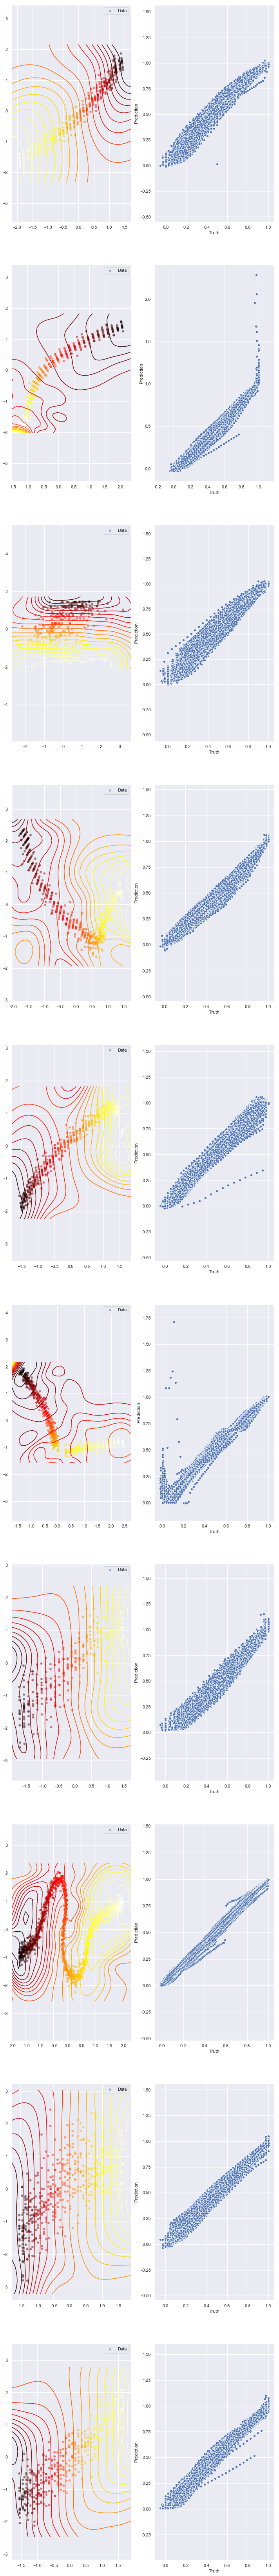

In [28]:
def synch_data(synch_gp, data):
    latlon = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(xy, axis=1)
    return synched_data

test = pd.read_pickle('test.pkl')
_fig, axs = plt.subplots(nrows=len(n_segs), ncols=2, figsize=(12, int(12*len(n_segs))))
for i, seg_n, model in zip(range(len(n_segs)), n_segs, gps.values()):
    seg = test[test.seg == seg_n]
    X = seg[['lat', 'lon']].values
    tau, _var = gp.predict(gps[int(seg_n)], X)
    df = pd.DataFrame({'Prediction': tau.T[0], 'Truth': seg.progress})
    model.model.plot(ax=axs[i, 0])
    axs[i, 0].set_aspect('equal', 'datalim')
    sns.scatterplot(data=df, x='Truth', y='Prediction', ax=axs[i, 1])
    axs[i, 1].set_aspect('equal', 'datalim')

In [29]:
for model in gps.values():
     gp.save(model)

A final test of the load functions and plotting of (training) predictions

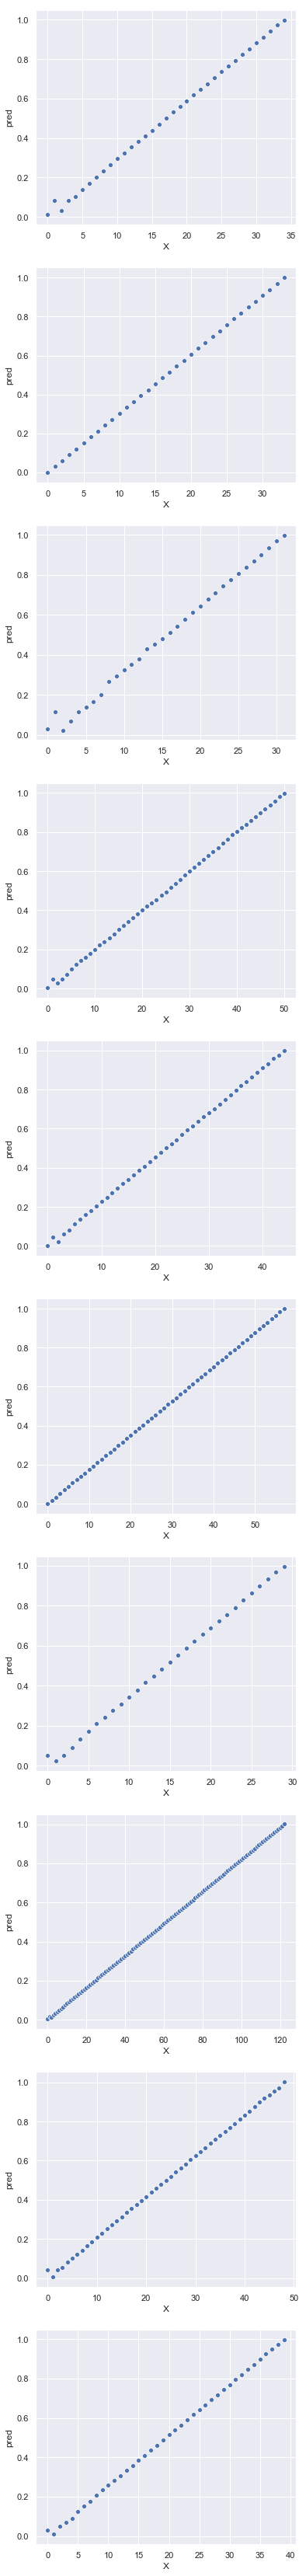

In [30]:
traj = train[train.traj == traj_n]
_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for i, seg_n in zip(range(len(n_segs)), n_segs):
    seg = traj[traj.seg == seg_n]
    sgp = gp.load_synch(route_n, seg_n)
    X = seg[['lat', 'lon']].values
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[i])